# Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from IPython.display import Image, HTML
import re
from IPython.core.display import display, HTML, Javascript
from string import Template
import json
import IPython.display
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
 
%matplotlib inline
py.init_notebook_mode(connected=True)

# Reading in data

In [2]:
# read in data
data = pd.read_csv('CompleteDataset.csv', encoding='utf-8')
# dropping index column
data = data.drop(data.columns[0], axis = 1)

In [3]:
# to check for present or absent positions
def in_preferred_position(list_pos, pos): 
    if pos in list_pos:
        return True
    return False

# Data Cleaning

In [4]:
# Converting preferred positions to a list
data['Preferred Positions'] = list(map(lambda x: x.split(), data['Preferred Positions']))

In [5]:
# Supporting function for converting string values into numbers
def str2number(amount):
    # values in Millions
    if amount[-1] == 'M':
        return float(amount[1:-1])*1000000
    # values in Thousands
    elif amount[-1] == 'K':
        return float(amount[1:-1])*1000
    else:
        return float(amount[1:])

# lambda function to apply str2number for each player's value    
data['Value'] = data['Value'].apply(lambda x: str2number(x))
# lambda function to apply str2number for each player's wage
data['Wage'] = data['Wage'].apply(lambda x: str2number(x)) 

In [6]:
# converting all columns to numeric wherever possible
# coerce errors wherever explanatory variables are present
data.apply(pd.to_numeric, errors='coerce')  
# function to split attributes where + is present
# convert first index to float ~ new attribute value
def convert_to_float(x):
    if len(x.split('+')) > 1:
        return float(x.split('+')[0])
    if len(x.split('-')) > 1:
        return float(x.split('-')[0])
    else:
        return float(x)

# list of attributes to change
a = [ 'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys']

# using map to apply convert_to_float to all attributes in a
for p in a:
    data[p] = list(map(convert_to_float, data[p]))

In [7]:
# dictionary for defining positions to their category
mapping = {'ST': 'Attack', 'RW': 'Attack', 'LW': 'Attack', 'RM': 'Midfield', 'CM': 'Midfield', 'LM': 'Midfield', 'CAM': 'Midfield', 'CF': 'Midfield', 'CDM': 'Midfield', 'CB': 'Defence', 'LB': 'Defence', 'RB': 'Defence', 'RWB': 'Defence', 'LWB': 'Defence', 'GK': 'Goalkeeper'}

# for position in mapping.keys(): 
# data[[in_preferred_position(x, position) for x in data['Preferred Positions']]]
    
for index, row in data.iterrows():
    data.loc[index, 'FieldPosition'] = mapping[row['Preferred Positions'][0]]

In [8]:
# mapping countries to their continents - dictionary
continents = {
    'Africa' : ['Algeria','Angola','Benin','Botswana','Burkina','Burundi','Cameroon','Cape Verde','Central African Republic','Chad','Comoros','Congo','DR Congo','Djibouti','Egypt','Equatorial Guinea','Eritrea','Ethiopia','Gabon','Gambia','Ghana','Guinea','Guinea Bissau','Ivory Coast','Kenya','Lesotho','Liberia','Libya','Madagascar','Malawi','Mali','Mauritania','Mauritius','Morocco','Mozambique','Namibia','Niger','Nigeria','Rwanda','Sao Tome and Principe','Senegal','Seychelles','Sierra Leone','Somalia','South Africa','South Sudan','Sudan','Swaziland','Tanzania','Togo','Tunisia','Uganda','Zambia','Zimbabwe','Burkina Faso'],
    'Antarctica' : ['Fiji','Kiribati','Marshall Islands','Micronesia','Nauru','Palau','Papua New Guinea','Samoa','Solomon Islands','Tonga','Tuvalu','Vanuatu'],
    'Asia' : ['Afghanistan','Bahrain','Bangladesh','Bhutan','Brunei','Burma (Myanmar)','Cambodia','China','China PR','East Timor','India','Indonesia','Iran','Iraq','Israel','Japan','Jordan','Kazakhstan','North Korea','South Korea','Korea Republic','Korea DPR','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia','Maldives','Mongolia','Nepal','Oman','Pakistan','Palestine','Philippines','Qatar','Russian Federation','Saudi Arabia','Singapore','Sri Lanka','Syria','Tajikistan','Thailand','Turkey','Turkmenistan','United Arab Emirates','Uzbekistan','Vietnam','Yemen','Russia'],
    'Australia Oceania' : ['Australia','New Caledonia', 'New Zealand'],
    'Europe' : ['Albania','Andorra','Armenia','Austria','Azerbaijan','Belarus','Belgium','Bosnia Herzegovina','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','FYR Macedonia','Georgia','Germany','Greece','Hungary','Iceland','Ireland','Italy','Kosovo','Latvia','Liechtenstein','Lithuania','Luxembourg','Macedonia','Malta','Moldova','Monaco','Montenegro','Netherlands','Northern Ireland','Norway','Poland','Portugal','Romania','San Marino','Scotland','Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland','Ukraine','England','Vatican City','Republic of Ireland','Wales'],
    'North America' : ['Antigua and Barbuda','Bahamas','Barbados','Belize','Canada','Costa Rica','Cuba','Dominica','Dominican Republic','El Salvador','Grenada','Guatemala','Haiti','Honduras','Jamaica','Mexico','Nicaragua','Panama','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Trinidad and Tobago','United States'],
    'South America' : ['Argentina','Bolivia','Brazil','Chile','Colombia','Curacao','Ecuador','Guyana','Paraguay','Peru','Suriname','Trinidad & Tobago','Uruguay','Venezuela']
}

In [9]:
#Creating a function that assigns continent to each country
def find_continent(x, continents_list):
    # Iteration over 
    for key in continents_list:
        if x in continents_list[key]:
            return key
    return np.NaN

#Applying the function and creating the continent column
data['Continent'] = data['Nationality'].apply(lambda x: find_continent(x, continents))

In [10]:
# sample of data
data.describe()

ID           Age       Overall     Potential         Value  \
count   15405.000000  15405.000000  15405.000000  15405.000000  1.540500e+04   
mean   207669.026615     25.137098     66.822590     71.702110  2.649844e+06   
std     31371.133629      4.508571      6.864503      6.086678  5.713453e+06   
min        16.000000     16.000000     46.000000     48.000000  0.000000e+00   
25%    193076.000000     22.000000     62.000000     67.000000  3.500000e+05   
50%    213170.000000     25.000000     67.000000     71.000000  7.500000e+05   
75%    230473.000000     28.000000     71.000000     76.000000  2.400000e+06   
max    241218.000000     44.000000     94.000000     94.000000  1.230000e+08   

                Wage       Special  Acceleration    Aggression       Agility  \
count   15405.000000  15405.000000  15405.000000  15405.000000  15405.000000   
mean    12760.986693   1606.033561     64.952483     56.315807     63.719507   
std     24506.195531    273.257835     14.900220     17.517100     14.833043   
min         0.000000    728.000000     11.000000     11.000000     14.000000   
25%      2000.000000   1464.000000     57.000000     44.000000     56.000000   
50%      5000.000000   1648.000000     68.000000     59.000000     66.000000   
75%     14000.000000   1797.000000     75.000000     70.000000     74.000000   
max    565000.000000   2291.000000     96.000000     96.000000     96.000000   

           ...                 RB           RCB           RCM           RDM  \
count      ...       13645.000000  13645.000000  13645.000000  13645.000000   
mean       ...          57.588128     56.129498     59.100989     57.501649   
std        ...           9.704794     12.160434      8.799248     10.211230   
min        ...          30.000000     25.000000     31.000000     26.000000   
25%        ...          50.000000     46.000000     53.000000     50.000000   
50%        ...          58.000000     58.000000     60.000000     58.000000   
75%        ...          65.000000     66.000000     65.000000     65.000000   
max        ...          84.000000     87.000000     87.000000     85.000000   

                 RF            RM            RS            RW           RWB  \
count  13645.000000  13645.000000  13645.000000  13645.000000  13645.000000   
mean      59.528252     60.605203     58.653939     59.872188     58.322462   
std        9.932358      9.324881      9.183150      9.985027      9.037688   
min       27.000000     28.000000     32.000000     26.000000     31.000000   
25%       53.000000     55.000000     52.000000     54.000000     52.000000   
50%       61.000000     62.000000     59.000000     61.000000     59.000000   
75%       66.000000     67.000000     65.000000     67.000000     65.000000   
max       92.000000     90.000000     92.000000     91.000000     84.000000   

                 ST  
count  13645.000000  
mean      58.653939  
std        9.183150  
min       32.000000  
25%       52.000000  
50%       59.000000  
75%       65.000000  
max       92.000000  

[8 rows x 67 columns]

# Continent wise distribution

In [11]:
# top 1000 players by overall rating
top_1000 = data.sort_values("Overall", ascending=False).reset_index().head(2000)[["Name", "Nationality", "Continent", "Overall", "Club"]]

In [12]:
#Data preparation of json file
#Identifying groupings within the different classes and feeding that into data
data_zoom = {}
data_zoom["name"] = "DISTRIBUTION OF TOP 1000 PLAYERS ACCORDING TO NATIONALITY"
data_zoom["children"] = []

# Split dataset into continents:
for continent in top_1000['Continent'].unique():
    
    continent_set = top_1000[top_1000["Continent"]==continent]
    continent_dict = {}
    continent_dict["name"] = continent
    continent_dict["children"] = []
    
    #Split into countries:
    for country in continent_set['Nationality'].unique():
        
        countries_set = continent_set[continent_set['Nationality']==country][['Name', 'Overall']]
        
        country_dict = {}
        country_dict["name"] = country
        country_dict["children"] = []
        
        #Get the players and overall
        for player in countries_set.values:
            
            player_dict = {}
            player_dict['name'] = player[0]
            player_dict['size'] = player[1]
            country_dict["children"].append(player_dict)
            
        continent_dict['children'].append(country_dict)
        
    data_zoom["children"].append(continent_dict)


In [13]:
#Plotting the D3.js visual
#Feeding into the HTML structure that will be used to embed the D3 SVG (Scalable Visual Graphic) object
#The relevant HTML is stored into a Python string within the Python triple quotation marks
html_string = """
<!DOCTYPE html>
<meta charset="utf-8">
<style>
.node {
  cursor: pointer;
}
.node:hover {
  stroke: #000;
  stroke-width: 1.5px;
}
.node--leaf {
  fill: white;
}
.label {
  font: 11px "Helvetica Neue", Helvetica, Arial, sans-serif;
  text-anchor: middle;
  text-shadow: 0 1px 0 #fff, 1px 0 0 #fff, -1px 0 0 #fff, 0 -1px 0 #fff;
}
.label,
.node--root,
.node--leaf {
  pointer-events: none;
}
</style>
<svg width="800" height="800"></svg>
"""


In [14]:
#Javascript embedding
#Feeding the base javascript that will ultimately be used to power the D3 plot
js_string="""
require.config({
    paths: {
        d3: "https://d3js.org/d3.v4.min"
     }
});

require(["d3"], function(d3) {

   console.log(d3);

var svg = d3.select("svg"),
    margin = 20,
    diameter = +svg.attr("width"),
    g = svg.append("g").attr("transform", "translate(" + diameter / 2 + "," + diameter / 2 + ")");

var color = d3.scaleSequential(d3.interpolateViridis)
    .domain([-4, 4]);
var pack = d3.pack()
    .size([diameter - margin, diameter - margin])
    .padding(2);
d3.json("output.json", function(error, root) {
  if (error) throw error;

root = d3.hierarchy(root)
      .sum(function(d) { return d.size; })
      .sort(function(a, b) { return b.value - a.value; });

var focus = root,
      nodes = pack(root).descendants(),
      view;

var circle = g.selectAll("circle")
        .data(nodes)
        .enter().append("circle")
        .attr("class", function(d) { return d.parent ? d.children ? "node" : "node node--leaf" : "node node--root"; })
        .style("fill", function(d) { return d.children ? color(d.depth) : null; })
        .on("click", function(d) { if (focus !== d) zoom(d), d3.event.stopPropagation(); });

  var text = g.selectAll("text")
      .data(nodes)
      .enter().append("text")
      .attr("class", "label")
      .style("fill-opacity", function(d) { return d.parent === root ? 1 : 0; })
      .style("display", function(d) { return d.parent === root ? "inline" : "none"; })
      .text(function(d) { return d.data.name; });
   
   var node = g.selectAll("circle,text");
   
   svg
      .style("background", color(-1))
      .on("click", function() { zoom(root); });
      
   zoomTo([root.x, root.y, root.r * 2 + margin]);
   
   function zoom(d) {
    var focus0 = focus; focus = d;

    var transition = d3.transition()
        .duration(d3.event.altKey ? 7500 : 750)
        .tween("zoom", function(d) {
          var i = d3.interpolateZoom(view, [focus.x, focus.y, focus.r * 2 + margin]);
          return function(t) { zoomTo(i(t)); };
        });

   transition.selectAll("text")
      .filter(function(d) { return d.parent === focus || this.style.display === "inline"; })
        .style("fill-opacity", function(d) { return d.parent === focus ? 1 : 0; })
        .on("start", function(d) { if (d.parent === focus) this.style.display = "inline"; })
        .on("end", function(d) { if (d.parent !== focus) this.style.display = "none"; });
  }
   function zoomTo(v) {
    var k = diameter / v[2]; view = v;
    node.attr("transform", function(d) { return "translate(" + (d.x - v[0]) * k + "," + (d.y - v[1]) * k + ")"; });
    circle.attr("r", function(d) { return d.r * k; });
  }
});
 });
"""


In [15]:
#Using the json module and by invoking the function "dump", we are able to conveniently send each element in the dictionary off into a json file: "output.json"
with open('output.json', 'w') as outfile:  
    json.dump(data_zoom, outfile)

In [16]:
#To display the html as well as the underlying javascript
h = display(HTML(html_string))
j = IPython.display.Javascript(js_string)
IPython.display.display_javascript(j)
#Please click on the clusters above. This plot is interactive and zoomable. Click on the outside if you want to get back to the original view

# Country wise Stats

In [17]:
# selecting relevant columns for grouping by nationality
reordered_cols = []
personal_cols = []
personal_cols = ['ID', 'Name', 'Photo', 'Club', 'Club Logo', 'Preferred Positions', 'Flag', 'Nationality', 'Wage', 'Value']
reordered_cols = personal_cols + [col for col in data if (col not in personal_cols)]
data = data[reordered_cols]

In [18]:
# Converting values to numeric wherever applicable
country_data = data.iloc[:, 6:]
country_data.iloc[:, 2:] = country_data.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

In [19]:
# Calculating country summary statistics
agg_dict = {}
agg_dict = {'Flag': ['min']}
for col in country_data.columns[2:]:
    agg_dict[col] = ['mean', 'max', 'min', 'size']
group_by_country = country_data.groupby(['Nationality'])
country_stats = group_by_country.agg(agg_dict)
country_stats[('Flag', 'min')] = '<img src="' + country_stats[('Flag', 'min')] + '">'
HTML(country_stats.head(10).to_html(escape=False))

In [20]:
# Function for creating trace for choreopleth graph data
def create_trace(feature, basic_stat, is_visible):
    trace = go.Choropleth(
        locations= country_stats.index,
        locationmode= 'country names',
        z= country_stats[(feature, basic_stat)],
        text= country_stats[(feature, 'size')],
        visible = is_visible,
        colorscale = [
            [0.0,"rgb(25, 100, 255)"],[0.2,"rgb(25, 175, 255)"],[0.4,"rgb(25, 255, 255)"],
            [0.6,"rgb(25, 255, 175)"],[0.8,"rgb(25, 255, 100)"],[1.0,"rgb(25, 255, 25)"]
            ],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            #autotick = True,
            tickprefix = '',
            outlinecolor = "rgba(68, 68, 68, 0)",
            #dtick = 2,
            title = feature + '<br>' + basic_stat)
    )
    return trace

In [21]:
# creating empty trace
trace_data = []
buttons= []
is_visible = True
features = country_data.columns[2:]
stats = ['mean', 'max', 'min']
n = len(features) * len(stats)
nth_feature = 0
nth_stat = 0

# Automatically generating traces for all the variables
for stat in stats:
    for feature in features:
        trace_data.append(create_trace(feature, stat, is_visible))
        is_visible = False
        
        pre_false = [False]*nth_feature
        post_false = [False]*(n-nth_feature-1)
        button = dict(
            label= feature + ' - ' + stat,
            method= 'update',
            args=[
                {'visible': pre_false + [True] + post_false},
                {'title': 'FIFA 2018 Statistics (' + feature + ' - ' + stat + ')'}
            ]
        )
        buttons.append(button)
        nth_feature += 1
        
# menu selection frame
  
updatemenus = list([
    dict(
        #type="buttons",
        direction='down',
        active=-1,
        xanchor='left',
        x=0,
        yanchor = 'top',
        y=1.065,
        showactive = True,
        buttons=buttons
    )
])

# plot alignments
annotations = list([
    dict(text='(Feature - Stat):',
         x=0,
         y=1.12, 
         yref='paper',
         align='left',
         showarrow=False)
])

# plot layout
layout = dict(
    title = 'Nation wise statistics (' + features[0] + ' - ' + stats[0] + ')' ,
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    ),
    showlegend=False,
    updatemenus=updatemenus,
    annotations=annotations
)

fig = dict( data=trace_data, layout=layout )
py.iplot( fig, validate=False, filename='fifa-2018-world-map' )

# Dream Team

In [22]:
# Best squad for a particular formation and club and country
def get_best_squad(formation, data, club='', country=''):
    df = data.copy()
    squad = []
    if country:
        df = df[df['Nationality'] == country.title()]
    if club:
        df = df[df['Club'] == club.title()]
    for position in formation:
        if (position == 'GK'):
            g = df[[in_preferred_position(x, position) for x in df['Preferred Positions']]]
            g = g.sort_values('Overall', ascending=False)
            player = g.iloc[0][['ID', 'Name', 'Nationality', 'Overall', 'Preferred Positions']]
            position_rating = player['Overall']
        else:
            ng = df[[in_preferred_position(x, position) for x in df['Preferred Positions']]]
            if ng.empty:
                ng = df
            ng = ng.sort_values(str(position), ascending=False)
            player = ng.iloc[0]
            position_rating = player[position]
            player = player[['ID', 'Name', 'Nationality', 'Overall', 'Preferred Positions']]   
        player['Position'] = str(position)
        player['Position Rating'] = position_rating
        squad.append(player)
        df = df[df['ID'] != player['ID']]
    squad = pd.DataFrame(np.array(squad).reshape(11,7), columns = ['ID','Name', 'Nationality', 'OVR', 'Preferred Positions', 'Position', 'Rating'])
    return squad

In [23]:
# squad formations
squad_433 = ['GK', 'LWB', 'LCB', 'CB', 'RB', 'LM', 'CDM', 'RM', 'LW', 'ST', 'RW']
s = get_best_squad(squad_433, data, country='', club='')
s[['Name', 'Rating', 'Position', 'Nationality']]

Name Rating Position Nationality
0            M. Neuer     92       GK     Germany
1             D. Rose     81      LWB     England
2        Sergio Ramos     87      LCB       Spain
3        G. Chiellini     86       CB       Italy
4         Azpilicueta     84       RB       Spain
5          A. Sánchez     85       LM       Chile
6            A. Vidal     85      CDM       Chile
7        K. De Bruyne     85       RM     Belgium
8   Cristiano Ronaldo     91       LW    Portugal
9           L. Suárez     88       ST     Uruguay
10           L. Messi     91       RW   Argentina

# Age vs Overall (with hue)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

# Load the example mpg dataset
mpg = data

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Age", y="Overall", hue="FieldPosition", size="Value",
            sizes=(40, 800), alpha=0.8, palette="muted",
            height=9, data=mpg)

AttributeError: module 'seaborn' has no attribute 'relplot'

# Top 10 Countries Overall Boxplot

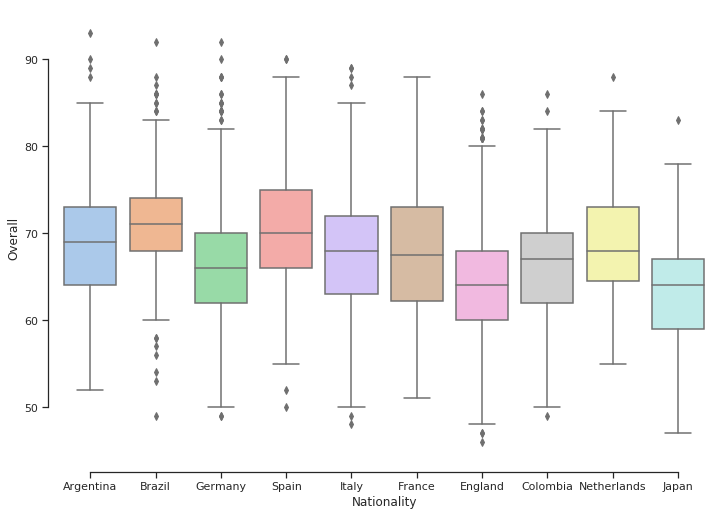

In [26]:
df = data.copy()
sns.set(style="ticks", palette="pastel")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)


top10 = list(df['Nationality'].value_counts().head(10).index)
d = df.query('Nationality in @top10')
box_overall = sns.boxplot(data = d, y = 'Overall', x = 'Nationality')
sns.despine(offset=10, trim=True)

# Top 10 Countries Potential Boxplot

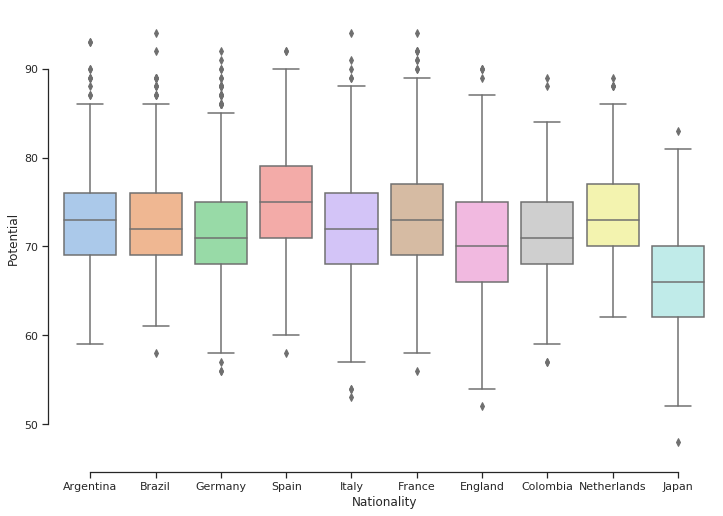

In [27]:
sns.set(style="ticks", palette="pastel")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

box_potential = sns.boxplot(data = d, y = 'Potential', x = 'Nationality')
sns.despine(offset=10, trim=True)

In [28]:
df_top10clubs = data[["Name", "Overall", "Club"]]
topclubs = df_top10clubs.groupby("Club", as_index= False).median().sort_values("Overall", ascending = False).head(10)
topclubs = list(topclubs["Club"])

In [29]:
df_top10clubs.groupby("Club", as_index= False).median().sort_values("Overall", ascending = False).head(10)

Club  Overall
465       Real Madrid CF     83.0
329             Juventus     83.0
221     FC Bayern Munich     82.5
218         FC Barcelona     82.0
375      Manchester City     81.5
431  Paris Saint-Germain     81.0
141              Chelsea     80.5
67       Atlético Madrid     80.0
376    Manchester United     79.5
51               Arsenal     79.5

# Top 10 Clubs Overall Boxplot

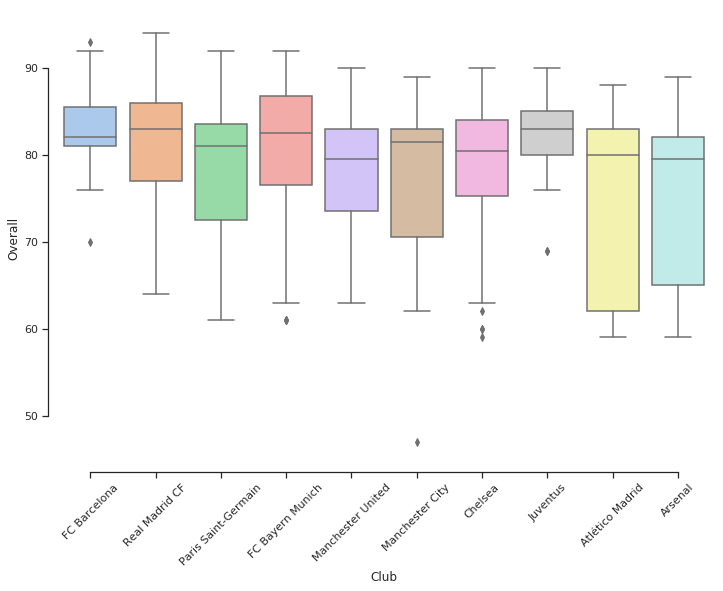

In [30]:
clubs = topclubs
c = data.query('Club in @clubs')

sns.set(style="ticks", palette="pastel")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

box_wage = sns.boxplot(data = c, y = 'Overall', x = 'Club')
sns.despine(offset=10, trim=True)
a = plt.setp(ax.get_xticklabels(), rotation=45)

# Top Clubs Potential boxplot

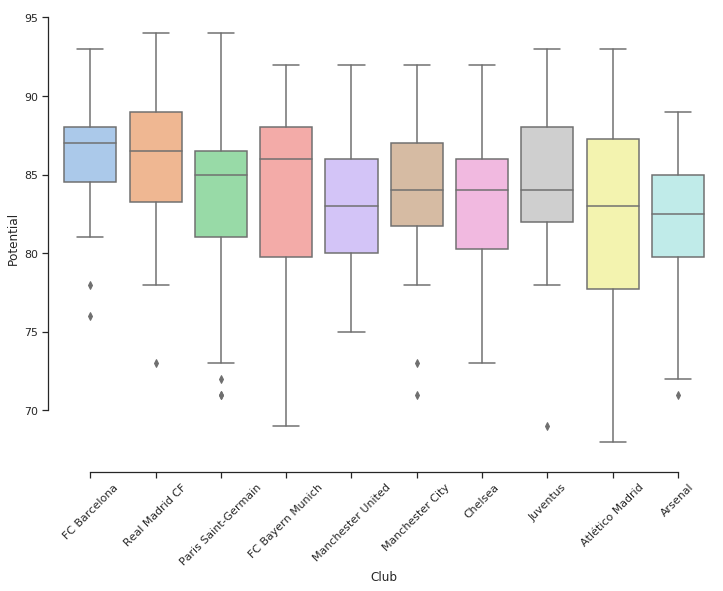

In [31]:
c = data.query('Club in @clubs')

sns.set(style="ticks", palette="pastel")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

box_wage = sns.boxplot(data = c, y = 'Potential', x = 'Club')
sns.despine(offset=10, trim=True)
a = plt.setp(ax.get_xticklabels(), rotation=45)

# Top Clubs Wage boxplot

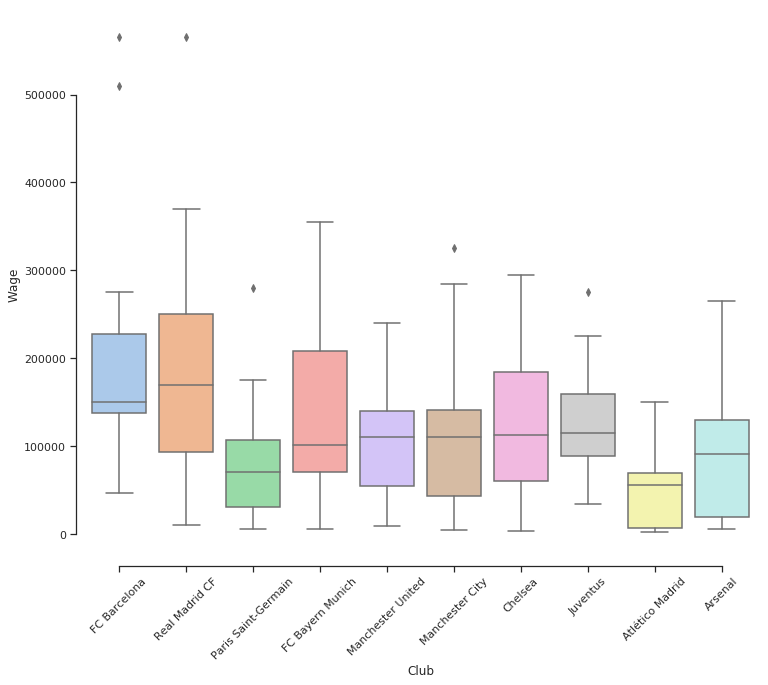

In [32]:
c = data.query('Club in @clubs')

sns.set(style="ticks", palette="pastel")
a4_dims = (12, 10)
fig, ax = plt.subplots(figsize=a4_dims)

box_wage = sns.boxplot(data = c, y = 'Wage', x = 'Club')
sns.despine(offset=10, trim=True)
a = plt.setp(ax.get_xticklabels(), rotation=45)

# Top Clubs Value boxplot

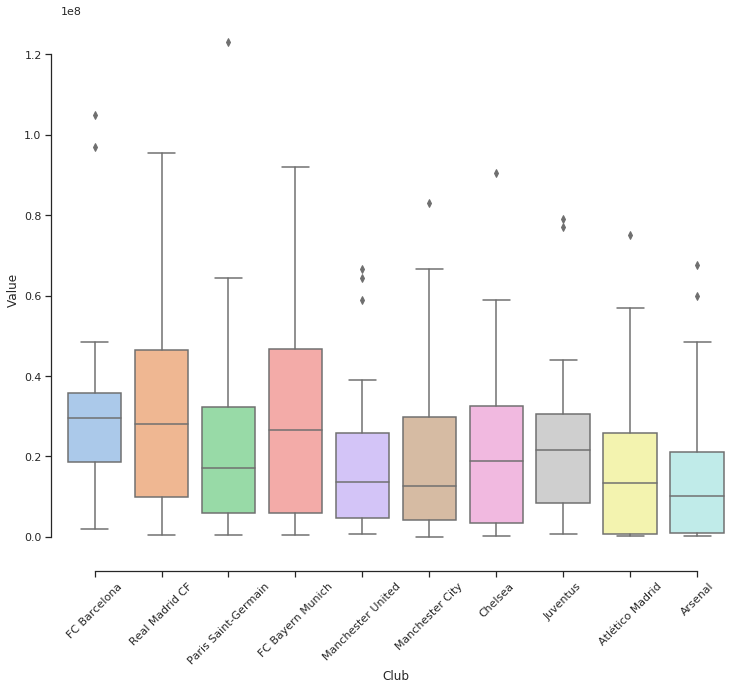

In [33]:
sns.set(style="ticks", palette="pastel")
a4_dims = (12, 10)
fig, ax = plt.subplots(figsize=a4_dims)
meds = c.median().sort_values()

box_wage = sns.boxplot(data = c, y = 'Value', x = 'Club')
sns.despine(offset=10, trim=True)

a = plt.setp(ax.get_xticklabels(), rotation=45)

# Overall/Potential vs Age

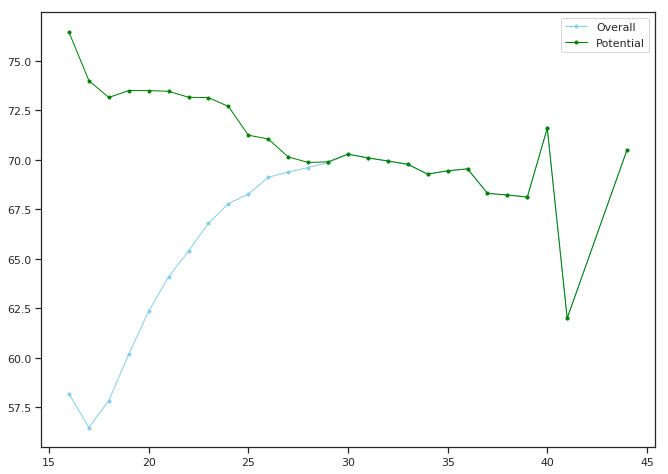

In [62]:
overall = pd.DataFrame(df.groupby(["Age"])['Overall'].mean())
potential = pd.DataFrame(df.groupby(["Age"])['Potential'].mean())
merged = pd.merge(overall, potential, on='Age', how='inner')
merged['Age']= merged.index
fig, ax = plt.subplots(figsize=(11, 8))
merged.reset_index(drop = True, inplace = True)
p = plt.plot('Age', 'Overall', data=merged, marker='.', color='skyblue', linewidth=1, label ="Overall" )
p = plt.plot('Age', 'Potential', data=merged, marker='.', color='green', linewidth=1, label = "Potential")
p = plt.legend()

# Correlation matrix for all numeric attributes

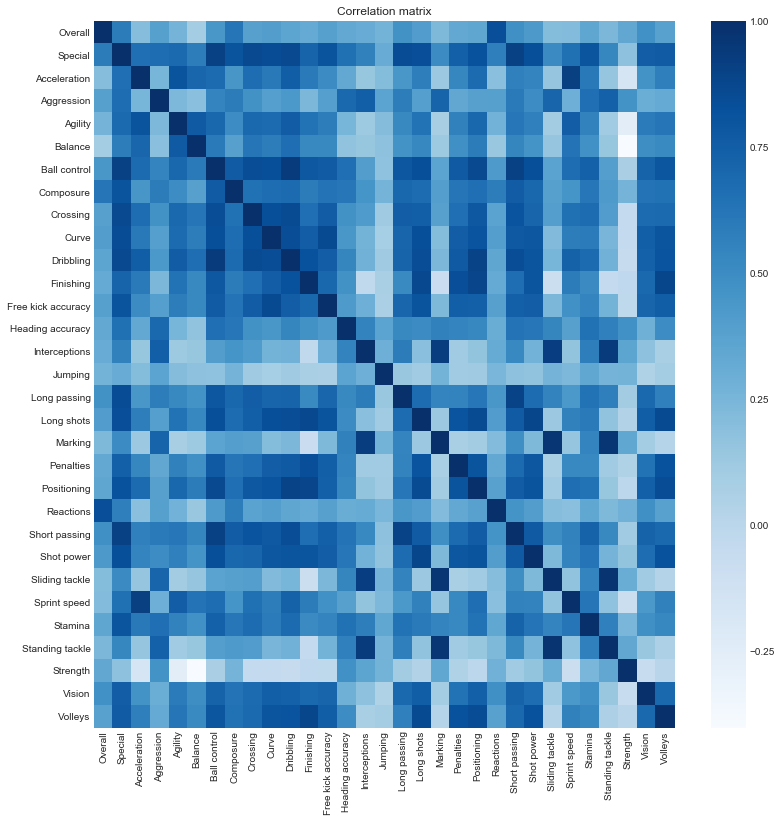

In [152]:
#Selects list of non-gola keeper attribute ratings and creates a correlation matrix(as a heatmap) with respect to Overall Rating
L = [11]+list(range(13,25))+list(range(30,48))
df = data.iloc[ :, L]
fig, ax = plt.subplots()
fig.set_size_inches(13,13)
ax = sns.heatmap(df.corr(),cmap = "Blues").set_title('Correlation matrix')

In [170]:
df_overall = df.corr()
# high correlation attributes
df_overall[df_overall['Overall']>=0.5]

Overall   Special  Acceleration  Aggression   Agility   Balance  \
Overall    1.000000  0.594735      0.204846    0.390804  0.261315  0.097751   
Special    0.594735  1.000000      0.655904    0.669152  0.691936  0.585909   
Composure  0.624680  0.806112      0.446907    0.590428  0.498300  0.382234   
Reactions  0.840747  0.578211      0.191520    0.387955  0.273506  0.140652   

           Ball control  Composure  Crossing     Curve    ...     Reactions  \
Overall        0.444657   0.624680  0.381366  0.408197    ...      0.840747   
Special        0.907658   0.806112  0.865638  0.847928    ...      0.578211   
Composure      0.766775   1.000000  0.647825  0.669193    ...      0.587221   
Reactions      0.421886   0.587221  0.371778  0.401933    ...      1.000000   

           Short passing  Shot power  Sliding tackle  Sprint speed   Stamina  \
Overall         0.483426    0.426181        0.212245      0.220846  0.349688   
Special         0.904984    0.834539        0.511222      0.651598  0.798664   
Composure       0.762379    0.703317        0.389361      0.452396  0.619299   
Reactions       0.458284    0.403169        0.203203      0.193044  0.348126   

           Standing tackle  Strength    Vision   Volleys  
Overall           0.240976  0.342090  0.479219  0.378237  
Special           0.539601  0.183396  0.756412  0.765301  
Composure         0.423489  0.264778  0.636523  0.646973  
Reactions         0.229441  0.278755  0.482273  0.380409  

[4 rows x 31 columns]

In [175]:
# Moderate correlation attributes
df_overall[(df_overall['Overall'] >= 0.4) & (df_overall['Overall'] < 0.5)]

Overall   Special  Acceleration  Aggression   Agility  \
Ball control   0.444657  0.907658      0.677129    0.545912  0.702668   
Curve          0.408197  0.847928      0.610713    0.394033  0.680401   
Long passing   0.469742  0.848010      0.443616    0.585539  0.519954   
Long shots     0.411208  0.836585      0.579753    0.394291  0.642037   
Short passing  0.483426  0.904984      0.568492    0.601941  0.614016   
Shot power     0.426181  0.834539      0.546668    0.501354  0.571481   
Vision         0.479219  0.756412      0.464757    0.299644  0.595115   

                Balance  Ball control  Composure  Crossing     Curve  \
Ball control   0.603854      1.000000   0.766775  0.842891  0.833081   
Curve          0.587346      0.833081   0.669193  0.834076  1.000000   
Long passing   0.467369      0.789564   0.699990  0.757009  0.711347   
Long shots     0.530715      0.834508   0.672140  0.746686  0.835529   
Short passing  0.542779      0.909607   0.762379  0.811998  0.779337   
Shot power     0.460935      0.830829   0.703317  0.711823  0.788099   
Vision         0.495814      0.722425   0.636523  0.685131  0.744123   

                 ...     Reactions  Short passing  Shot power  Sliding tackle  \
Ball control     ...      0.421886       0.909607    0.830829        0.371830   
Curve            ...      0.401933       0.779337    0.788099        0.225424   
Long passing     ...      0.442814       0.896658    0.674861        0.553345   
Long shots       ...      0.409645       0.766251    0.882937        0.132807   
Short passing    ...      0.458284       1.000000    0.773491        0.492469   
Shot power       ...      0.403169       0.773491    1.000000        0.230673   
Vision           ...      0.482273       0.720967    0.669480        0.109741   

               Sprint speed   Stamina  Standing tackle  Strength    Vision  \
Ball control       0.668830  0.732818         0.402496  0.071447  0.722425   
Curve              0.585966  0.600005         0.251933 -0.045099  0.744123   
Long passing       0.431052  0.642278         0.576688  0.104788  0.696038   
Long shots         0.564349  0.600526         0.169108  0.038405  0.750820   
Short passing      0.559637  0.721285         0.523077  0.112624  0.720967   
Shot power         0.555628  0.631411         0.265113  0.163433  0.669480   
Vision             0.432975  0.480831         0.141812 -0.058750  1.000000   

                Volleys  
Ball control   0.792800  
Curve          0.801126  
Long passing   0.569694  
Long shots     0.861769  
Short passing  0.698137  
Shot power     0.823166  
Vision         0.698760  

[7 rows x 31 columns]

# Player Age vs Average Value

In [36]:
data_top1000 = data
# Grouping the data by Age as index and displaying Value and Wage as per age groups  
age_wagevalue = data_top1000[data_top1000.Age<=38].groupby(['Age']).agg({'Wage': 'mean', 'Value': 'mean'})      

# Plotting Value over Age with Line and Bar
                                   
data_plot1 = [
    go.Scatter(
        x=age_wagevalue.index, 
        y=age_wagevalue['Value'],
        marker = dict(
          color = 'rgb(0,0,153)'
        ),
                name = "Average Player Value as Line"
            ),
    go.Bar(
        x = age_wagevalue.index,
        y=age_wagevalue['Value'],
        base = 0,
        marker = dict(
          color = 'rgb(51,153,255)'
        ),
                name = "Average Player Value as Bars"
    )
]

layout_plot1 = go.Layout(
    title='Value of players over Age',
    yaxis=dict(title='Average Player Value in Euros(Millions)'),
    xaxis=dict(title='Player Age')
)

fig1 = go.Figure(data=data_plot1, layout=layout_plot1)
    
py.iplot(fig1)

# Player age vs Wage

In [37]:
data_plot2 = [
    go.Scatter(
        x=age_wagevalue.index, 
        y=age_wagevalue['Wage'],
        marker = dict(
          color = 'rgb(0,204,204)'
        ),
                name = "Average Player Wage as Line"
            ),
    go.Bar(
        x = age_wagevalue.index,
        y=age_wagevalue['Wage'],
        base = 0,
        marker = dict(
          color = 'rgb(0,102,102)'
        ),
                name = "Average Player Wage as Bars"
    )
]

layout_plot2 = go.Layout(
    title='Monthly Wage of players over Age',
    yaxis=dict(title='Average Wage in Euros(Thousands)'),
    xaxis=dict(title='Player Age'),
    )

fig2 = go.Figure(data=data_plot2, layout=layout_plot2)
    
py.iplot(fig2,filename ='Monthly Wage of players over Age.html')



In [38]:
# Violin Plot for Value over Age
data_plot3 = []
for i in range(0,len(pd.unique(data_top1000['Age']))):
    trace = {
            "type": 'violin',
            "x": data_top1000['Age'][data_top1000['Age'] == pd.unique(data_top1000['Age'])[i]],
            "y": data_top1000['Value'][data_top1000['Age'] == pd.unique(data_top1000['Age'])[i]],
            "name": pd.unique(data_top1000['Age'])[i],
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        }
    data_plot3.append(trace)

        
fig3 = {
    "data": data_plot3,
    "layout" : {
        "title": "Distribution of Player Value over Player Age",
        "yaxis": {
            "zeroline": False,
            "title":"Player Value in Euros (Millions)" 
        },
        "xaxis": {
                "title":"Player Age"}
    }
}

py.iplot(fig3, validate = False)

In [39]:
# Violin Plot for Wage over Age
data_plot4 = []
for i in range(0,len(pd.unique(data_top1000['Age']))):
    trace = {
            "type": 'violin',
            "x": data_top1000['Age'][data_top1000['Age'] == pd.unique(data_top1000['Age'])[i]],
            "y": data_top1000['Wage'][data_top1000['Age'] == pd.unique(data_top1000['Age'])[i]],
            "name": pd.unique(data_top1000['Age'])[i],
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        }
    data_plot4.append(trace)

        
fig4 = {
    "data": data_plot4,
    "layout" : {
        "title": "Distribution of Player Wage over Player Age",
        "yaxis": {
            "zeroline": False,
        "title":"Wage in Euros (Thousands)" 
        },
        "xaxis": {
                "title":"Player Age"
                }
    }
    }


py.iplot(fig4, filename='Wage_Age_Violin.html', validate = False)

# Player Value distribution by position

In [40]:
CAM = data[[in_preferred_position(x, 'CAM') for x in data['Preferred Positions']]].sort_values('CAM', ascending=False)[:100]
CAM["PPos"] = "Central Attacking Midfielder"

CB = data[[in_preferred_position(x, 'CB') for x in data['Preferred Positions']]].sort_values(by="CB",ascending=False)[:100]
CB["PPos"] = "Center Back"

CDM = data[[in_preferred_position(x, 'CDM') for x in data['Preferred Positions']]].sort_values(by="CDM",ascending=False)[:100]
CDM["PPos"] = "Central Defensive Midfielder"

CF = data[[in_preferred_position(x, 'CF') for x in data['Preferred Positions']]].sort_values(by="CF",ascending=False)[:100]
CF["PPos"] = "Center Forward"

CM = data[[in_preferred_position(x, 'CM') for x in data['Preferred Positions']]].sort_values(by="CM",ascending=False)[:100]
CM["PPos"] = "Central Midfielder"

LB = data[[in_preferred_position(x, 'LB') for x in data['Preferred Positions']]].sort_values(by="LB",ascending=False)[:100]
LB["PPos"] = "Left Back"

LM = data[[in_preferred_position(x, 'LM') for x in data['Preferred Positions']]].sort_values(by="LM",ascending=False)[:100]
LM["PPos"] = "Left Midfielder"

LW = data[[in_preferred_position(x, 'LW') for x in data['Preferred Positions']]].sort_values(by="LW",ascending=False)[:100]
LW["PPos"] = "Left Wing"

LWB = data[[in_preferred_position(x, 'LWB') for x in data['Preferred Positions']]].sort_values(by="LWB",ascending=False)[:100]
LWB["PPos"] = "Left Wing Back"

RB = data[[in_preferred_position(x, 'RB') for x in data['Preferred Positions']]].sort_values(by="RB",ascending=False)[:100]
RB["PPos"] = "Right Back"

RM = data[[in_preferred_position(x, 'RM') for x in data['Preferred Positions']]].sort_values(by="RM",ascending=False)[:100]
RM["PPos"] = "Right Midfielder"

RW = data[[in_preferred_position(x, 'RW') for x in data['Preferred Positions']]].sort_values(by="RW",ascending=False)[:100]
RW["PPos"] = "Right Wing"

RWB = data[[in_preferred_position(x, 'RWB') for x in data['Preferred Positions']]].sort_values(by="RWB",ascending=False)[:100]
RWB["PPos"] = "Right Wing Back"

ST = data[[in_preferred_position(x, 'ST') for x in data['Preferred Positions']]].sort_values(by="ST",ascending=False)[:100]
ST["PPos"] = "Striker"

GK = data[[in_preferred_position(x, 'GK') for x in data['Preferred Positions']]].sort_values(by="Overall",ascending=False)[:100]
GK["PPos"] = "Goal Keeper"

In [41]:
trace1 = go.Box(
    y = LW["Value"],
    name = "Left Wing Forward",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,204,102)'),
    line = dict(
        color = 'rgb(0,204,102)')
)

trace2 = go.Box(
    y = LM["Value"],
    name = "Left Midfielder",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,204,204)'),
    line = dict(
        color = 'rgb(0,204,204)')
)  

trace3 = go.Box(
    y = LWB["Value"],
    name = "Left Wing Back",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,153,153)'),
    line = dict(
        color = 'rgb(0,153,153)')
)

trace4 = go.Box(
    y = LB["Value"],
    name = "Left Back",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,102,102)'),
    line = dict(
        color = 'rgb(0,102,102)')
)      

trace5 = go.Box(
    y = CF["Value"],
    name = "Center Forward",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(102,102,255)'),
    line = dict(
        color = 'rgb(102,102,255)')
)

trace6 = go.Box(
    y = CAM["Value"],
    name = "Central Attacking Midfielder",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(51,51,255)'),
    line = dict(
        color = 'rgb(51,51,255)')
)  

trace7 = go.Box(
    y = CM["Value"],
    name = "Central Midfielder",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,0,204)'),
    line = dict(
        color = 'rgb(0,0,204)')
)

trace8 = go.Box(
    y = CDM["Value"],
    name = "Central Defensive Midfielder",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,0,153)'),
    line = dict(
        color = 'rgb(0,0,153)')
)
    
trace9 = go.Box(
    y = CB["Value"],
    name = "Center Back",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,0,153)'),
    line = dict(
        color = 'rgb(0,0,153)')
)    

trace10 = go.Box(
    y = RW["Value"],
    name = "Right Wing Forward",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,128,255)'),
    line = dict(
        color = 'rgb(0,128,255)')
)  

trace11 = go.Box(
    y = RM["Value"],
    name = "Right Midfielder",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,102,204)'),
    line = dict(
        color = 'rgb(0,102,204)')
)

trace12 = go.Box(
    y = RWB["Value"],
    name = "Right Wing Back",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,76,153)'),
    line = dict(
        color = 'rgb(0,76,153)')
)
    
trace13 = go.Box(
    y = RB["Value"],
    name = "Right Back",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,51,102)'),
    line = dict(
        color = 'rgb(0,51,102)')
)      

trace14 = go.Box(
    y = ST["Value"],
    name = "Striker",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,102,53)'),
    line = dict(
        color = 'rgb(0,102,53)')
)
    
trace15 = go.Box(
    y = GK["Value"],
    name = "Goal Keeper",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(102,0,102)'),
    line = dict(
        color = 'rgb(102,0,102)')
)    
data_plot = [trace1,trace2,trace3,trace4,trace5,trace6,trace7,trace8,trace9,trace10,trace11,trace12,trace13,trace14,trace15]

layout = go.Layout(
    title = "Player Value at Different Positions"
)

fig = go.Figure(data=data_plot,layout=layout)
py.iplot(fig, filename = "Value over Position.html")

# Player Value distribution by Field Position

In [42]:
Att = data[data['FieldPosition'] == 'Attack'].sort_values('Overall', ascending=False)[:100]
Mid = data[data['FieldPosition'] == 'Midfield'].sort_values('Overall', ascending=False)[:100]
Def = data[data['FieldPosition'] == 'Defence'].sort_values('Overall', ascending=False)[:100]
Gk = data[data['FieldPosition'] == 'Goalkeeper'].sort_values('Overall', ascending=False)[:100]

In [43]:
trace1 = go.Box(
    y = Att["Value"],
    name = "Attack",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,204,102)'),
    line = dict(
        color = 'rgb(0,204,102)')
)

trace2 = go.Box(
    y = Mid["Value"],
    name = "Midfielder",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,204,204)'),
    line = dict(
        color = 'rgb(0,204,204)')
)  

trace3 = go.Box(
    y = Def["Value"],
    name = "Defence",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(0,153,153)'),
    line = dict(
        color = 'rgb(0,153,153)')
)
trace4 = go.Box(
    y = Gk["Value"],
    name = "Goalkeeper",
    boxpoints = 'outliers',
    marker = dict(
        color = 'rgb(102,0,102)'),
    line = dict(
        color = 'rgb(102,0,102)')
)

data_plot = [trace1,trace2,trace3,trace4]

layout = go.Layout(
    title = "Player Value at Different Positions"
)

fig = go.Figure(data=data_plot,layout=layout)
py.iplot(fig, filename = "Value over Position.html")

In [44]:
train_columns = ['Special', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'Age', 'FieldPosition']

In [45]:
model_data = data.copy()
model_data = model_data[model_data['FieldPosition'] != 'Goalkeeper']
mapping = {'Attack' : 0, 'Midfield': 1, 'Defence': 2}
model_data = model_data.replace({'FieldPosition': mapping})

In [46]:
X = model_data[['Special', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'Age']]
Y = model_data['FieldPosition']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 440  182    6]
 [ 152 1261  153]
 [   1  153 1064]]
Normalized confusion matrix
[[7.01e-01 2.90e-01 9.55e-03]
 [9.71e-02 8.05e-01 9.77e-02]
 [8.21e-04 1.26e-01 8.74e-01]]


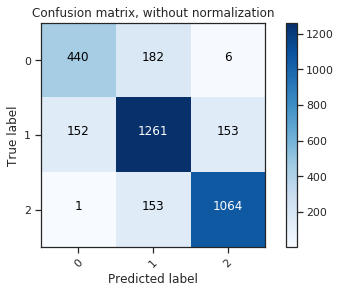

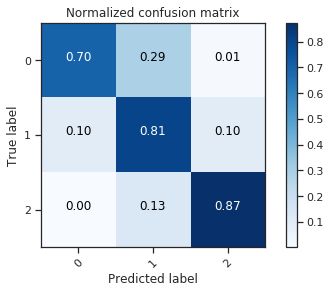

In [49]:
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,  classes=[0,1,2],
                      title='Normalized confusion matrix')

plt.show()

In [50]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
Coef_list = list(sorted(zip(X_train.columns, abs(lr.coef_[0])),key=lambda x: -x[1]))
Coef_table = pd.DataFrame(np.array(Coef_list).reshape(-1,2), columns = ['Attributes', 'Coef'])

print (Coef_table)

            Attributes                    Coef
0            Finishing     0.09187908935469322
1          Positioning     0.04294413649854606
2         Long passing    0.034394793890987395
3            Reactions     0.03356310980569168
4              Volleys     0.02922170807979512
5        Short passing    0.024554753581556697
6         Ball control    0.019851379649650565
7             Crossing     0.01869540014896692
8          GK reflexes    0.016953298324941423
9              Marking    0.016796213892711038
10        Sprint speed     0.01670935869115817
11           Composure     0.01610321112900909
12                 Age    0.015889161219212848
13           Dribbling    0.015027409230300182
14    Heading accuracy    0.014396676847212884
15          Aggression    0.013151700517147315
16     Standing tackle    0.012512964989420299
17          Long shots    0.012039549370876545
18      Sliding tackle    0.011654270600717297
19               Curve    0.009939187677684393
20       Inte

In [52]:
target_cols = Coef_table[:10]['Attributes'].tolist()

clf_2 = LogisticRegression().fit(X_train[target_cols], y_train)
acc_2 = clf_2.score(X_test[target_cols], y_test)
print ('Logistic Regression Accuracy (10 features): {}'.format(acc_2))

Logistic Regression Accuracy (10 features): 0.7995310668229777


Confusion matrix, without normalization
[[ 426  196    6]
 [ 134 1267  165]
 [   2  181 1035]]
Normalized confusion matrix
[[0.68 0.31 0.01]
 [0.09 0.81 0.11]
 [0.   0.15 0.85]]


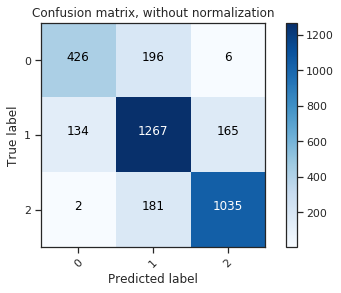

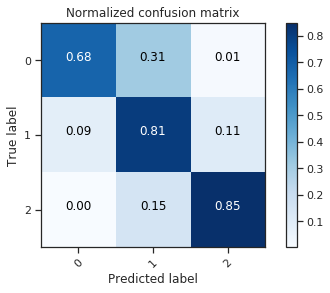

In [53]:
cnf_matrix = confusion_matrix(y_test, clf_2.predict(X_test[target_cols]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,  classes=[0,1,2],
                      title='Normalized confusion matrix')

plt.show()

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [55]:
clf = RandomForestClassifier(max_depth=200, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=200, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [56]:
preds = clf.predict(X_test)

Confusion matrix, without normalization
[[ 452  173    3]
 [ 186 1218  162]
 [   1  203 1014]]
Normalized confusion matrix
[[7.20e-01 2.75e-01 4.78e-03]
 [1.19e-01 7.78e-01 1.03e-01]
 [8.21e-04 1.67e-01 8.33e-01]]


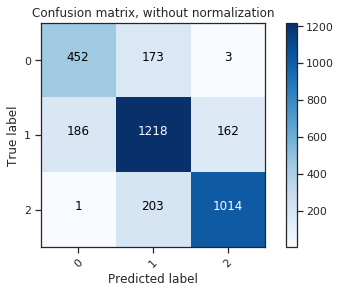

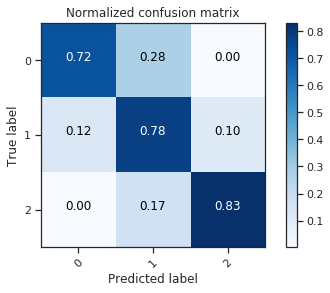

In [57]:
clf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(clf_matrix, classes=[0,1,2],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(clf_matrix, normalize=True,  classes=[0,1,2],
                      title='Normalized confusion matrix')

plt.show()